# Plotting Jazayeri & Shadlen (2010) data

Code to reproduce the plot in their paper: https://www.nature.com/articles/nn.2590.pdf

**Student Name: Varun Ravi Varma**

**Student Number: s3893030**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from chunk import Chunk
from model import Model
import random
import math

### Time perception functions

**Noise Function**

In [2]:
def noise(s):
    rand = random.uniform(0.001,0.999)
    return s * math.log((1 - rand)/rand)

**Time to Pulses Function**

In [3]:
def time_to_pulses(time, t_0 = 0.011, a = 1.1, b = 0.015, add_noise = True):
    
    pulses = 0
    pulse_duration = t_0
    
    while time >= pulse_duration:
        time = time - pulse_duration
        pulses = pulses + 1
        pulse_duration = a * pulse_duration + add_noise * noise(b * a * pulse_duration)
        
    return pulses

**Pulses to Time Function**

In [4]:
def pulses_to_time(pulses, t_0 = 0.011, a = 1.1, b = 0.015, add_noise = True):
    
    time = 0
    pulse_duration = t_0
    
    while pulses > 0:
        time = time + pulse_duration
        pulses = pulses - 1
        pulse_duration = a * pulse_duration + add_noise * noise(b * a * pulse_duration)
    
    return time

Importing the dataset, in order to utilize the distinct sample interval time steps that were used in the experiment.

In [5]:
dat = pd.read_csv("dataJS.csv")

### Defining the Model

In [6]:
# Store a time interval as a pulse signature into the declarative memory component
def store_to_chunk(time_intervals, interval_cond):
    n = 0
    for interval in time_intervals:
        m.add_encounter(Chunk(interval_cond+"-"+str(n), slots={"type": "numbers", "pulse": time_to_pulses(interval)}))
        m.time += 3.0
        n += 1
    return 

In [7]:
def run_expt(participant_pool=10, trial_count=1500):
    # Trial conditions are enumerated as short:1, intermediate:2, long:3
    trial_cond = [1, 2, 3]
    
    # Define a result dataframe to store condition, trial number, sample interval and response interval
    res = pd.DataFrame(columns=["Cond", "Trial", "Ts", "Tp"], dtype=float)
    
    # Run the trials for each participant, distributing the 3 conditions equally for each participant
    for participant in range(participant_pool):
        for condition in trial_cond:
            m = Model()
            m.time += np.random.uniform(1, 2)
            
            for trial in range(trial_count):
                # Adding Inter-trial time
                m.time += 1 + np.random.uniform(0.25, 0.85)
                # Choosing the interval from data based on the condition
                intervals = dat.loc[dat["Cond"]==condition]
                # Choosing a sample interval from the intervals retrieved previously
                time_int = random.choice(list(intervals["Ts"]))
                # Adding the time (as a pulse signature) to a chunk with condition and trial information as name
                m.add_encounter(Chunk("Cond-"+str(condition)+"-"+str(trial) , slots={"type": "numbers", "pulse": time_to_pulses(time_int)}))
                # Adding the time interval to the model time
                m.time += time_int
                # Blending previous experiences
                blend_data = Chunk("short", slots={"type": "numbers"})
                # Retrieving blended experience and updating time
                retrieve_blend = m.retrieve_blended_trace(blend_data, "pulse")
                m.time += retrieve_blend[0]
                # Storing the response time
                Tp = pulses_to_time(retrieve_blend[0])
                # Updating the results dataframe
                res.loc[len(res)] = [condition, trial, time_int, Tp]
    res = res.loc[res['Trial']>round(trial_count/3)]
    return res

### Experiment stage
Running the experiment for 20 participants with 1000 trials per participant and storing the results in a dataframe.

In [8]:
results = run_expt(20, 1000)

## Plotting the results obtained from the simulation of the experiment

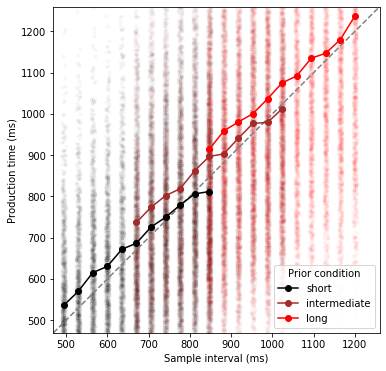

In [9]:
mean_tp = results.groupby(['Cond', 'Ts'])['Tp'].mean().reset_index()

yrange = np.multiply((min(mean_tp['Ts']), max(mean_tp['Ts'])), [0.95, 1.05])

# Subset data for plotting

cond1 = mean_tp.loc[mean_tp['Cond'] == 1]
cond2 = mean_tp.loc[mean_tp['Cond'] == 2]
cond3 = mean_tp.loc[mean_tp['Cond'] == 3]

# Add jitter noise
jitter = results.copy()
jitter['Ts'] = jitter['Ts'] + np.random.uniform(-5, 5, len(results))
cond1_jitter = jitter.loc[jitter['Cond'] == 1]
cond2_jitter = jitter.loc[jitter['Cond'] == 2]
cond3_jitter = jitter.loc[jitter['Cond'] == 3]

# Make plot
f, ax = plt.subplots(figsize = (6,6))

ax.set(xlim = yrange, ylim = yrange)
f.gca().set_aspect('equal', adjustable = 'box')

ax.set_xlabel('Sample interval (ms)')
ax.set_ylabel('Production time (ms)')

ax.plot(yrange, yrange, linestyle = '--', color ='gray')

ax.scatter(cond1_jitter['Ts'], cond1_jitter['Tp'], marker = '.', color = 'black', alpha = 0.025, label = None)
ax.scatter(cond2_jitter['Ts'], cond2_jitter['Tp'], marker = '.', color = 'brown', alpha = 0.025, label = None)
ax.scatter(cond3_jitter['Ts'], cond3_jitter['Tp'], marker = '.', color = 'red', alpha = 0.025, label = None)

ax.plot(cond1['Ts'], cond1['Tp'], color = 'black', marker = 'o', label = "short")
ax.plot(cond2['Ts'], cond2['Tp'], color = 'brown', marker = 'o', label = "intermediate")
ax.plot(cond3['Ts'], cond3['Tp'], color = 'red', marker = 'o', label = "long")

ax.legend(title = 'Prior condition', loc = 4)

## Inference

We see that the relation between Sample Intervals and Production Time is not 1:1, the slopes of the lines are lesser than 1 and there are certain fluctuations in the behaviour of the model.

Thus the model is not accurate, although the behaviour seems to follow the general pattern that was seen in the Jazayeri and Shadlen experiment.

### Sample Output Plot 

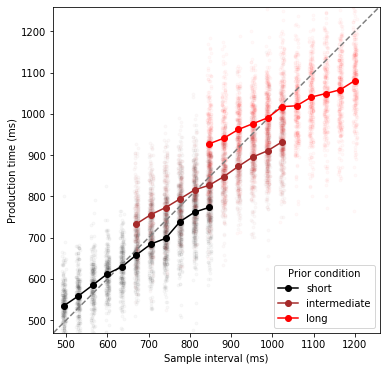

In [10]:
# Remove training trials
dat = dat[dat['Main'] == True]

# Calculate mean Tp by condition
mean_tp_by_subj = dat.groupby(['Subj', 'Cond', 'Ts'])['Tp'].mean().reset_index()
mean_tp = mean_tp_by_subj.groupby(['Cond', 'Ts'])['Tp'].mean().reset_index()

yrange = np.multiply((min(mean_tp['Ts']), max(mean_tp['Ts'])), [0.95, 1.05])

# Subset data for plotting

cond1 = mean_tp.loc[mean_tp['Cond'] == 1]
cond2 = mean_tp.loc[mean_tp['Cond'] == 2]
cond3 = mean_tp.loc[mean_tp['Cond'] == 3]

# Add jitter noise
jitter = dat.copy()
jitter['Ts'] = jitter['Ts'] + np.random.uniform(-5, 5, len(dat))
cond1_jitter = jitter.loc[jitter['Cond'] == 1]
cond2_jitter = jitter.loc[jitter['Cond'] == 2]
cond3_jitter = jitter.loc[jitter['Cond'] == 3]

# Make plot
f, ax = plt.subplots(figsize = (6,6))

ax.set(xlim = yrange, ylim = yrange)
f.gca().set_aspect('equal', adjustable = 'box')

ax.set_xlabel('Sample interval (ms)')
ax.set_ylabel('Production time (ms)')

ax.plot(yrange, yrange, linestyle = '--', color ='gray')

ax.scatter(cond1_jitter['Ts'], cond1_jitter['Tp'], marker = '.', color = 'black', alpha = 0.025, label = None)
ax.scatter(cond2_jitter['Ts'], cond2_jitter['Tp'], marker = '.', color = 'brown', alpha = 0.025, label = None)
ax.scatter(cond3_jitter['Ts'], cond3_jitter['Tp'], marker = '.', color = 'red', alpha = 0.025, label = None)

ax.plot(cond1['Ts'], cond1['Tp'], color = 'black', marker = 'o', label = "short")
ax.plot(cond2['Ts'], cond2['Tp'], color = 'brown', marker = 'o', label = "intermediate")
ax.plot(cond3['Ts'], cond3['Tp'], color = 'red', marker = 'o', label = "long")

ax.legend(title = 'Prior condition', loc = 4)